In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [3]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        if uniqueEntities[i]["SHARPE"] > 1.0 and uniqueEntities[i]["TREYNOR"] > 0.0\
            and uniqueEntities[i]["ACTIVITY"] > 0.7 and uniqueEntities[i]["ROLLING SHARPE BETA"] < 0.2:
            uniqueModelsToKeep.append(uniqueModels[i])
        else:
            continue
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [28]:
# uniqueModels = getAllUniqueModels()

***ORIGINAL MODELS***
((10, ('FXE', 2, None, None), 5, 'VTI'), 10, 250)
((10, ('IEF', 3, None, None), 3, 'EWT'), 10, 250)
((22, ('QQQ', 10, None, None), 2, 'EEM'), 22, 25)
((10, ('IJR', 34, None, 6), 3, 'ITB'), 10, 50)
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IVV', 4, 19, 9), 3, 'EWU'), 22, 50)
((10, ('EWT', 33, None, None), 3, 'XLY'), 10, 50)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('EWT', 33, None, None), 5, 'XLY'), 10, 100)
((10, ('IEF', 25, None, None), 5, 'VTI'), 10, 25)
((22, ('DXJ', 18, 16, 21), 5, 'VUG'), 22, 250)
((22, ('IEF', 27, None, 9), 3, 'IVW'), 22, 25)
((22, ('FXE', 29, 18, 19), 5, 'XLI'), 22, 25)
((10, ('EWH', 5, None, 10), 3, 'EWT'), 10, 100)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((22, ('VIG', 6, None, 12), 3, 'IJH'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((10, ('VGK', 38, None, 16), 3, 'XLB'), 10, 100)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((22, ('XLV', 26, None, None), 5, 'OEF'), 22, 25)
((10, ('T

In [4]:
uniqueModels = getUniqueModelsForTicker("GDX")

***ORIGINAL MODELS***
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 25)
***UNIQUE MODELS***
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
25TH PERCENTILE SHARPE -0.14970111735867908
ACTIVITY 0.9441786283891547
ALPHA 0.12719870393113486
ANNUALIZED RETURN 0.11626383306971078
BETA 0.041702532629313616
MIN ROLLING SHARPE -1.5174642080194425
OOS_ACTIVITY 0.9603174603174603
OOS_ALPHA 0.2035714449476947
OOS_ANNUALIZED RETURN 0.18155832721648268
OOS_BETA 0.08381624616145443
OOS_RAW BETA 0.03855846774193557
OOS_RELATIVE SHARPE -2.5308925727811085
OOS_SHARPE 1.014117713982195
OOS_SHARPE DIFFERENCE 1.676553296996286
OOS_SOLAR 2.49097132892042
OOS_STABILITY 0.555958714616726
OOS_TOTAL DAYS SEEN 252
OOS_TREYNOR 5.366433529817937
RAW BETA 0.1408029538717552
RELATIVE SHARPE 2.590238486380557
ROLLING SHARPE BETA 0.6044413851123722
ROLLING SHARPE ERROR 0.9676161668233925
ROLLING SHARPE STABILITY 0.6285456652094477
SHARPE 0.6463373941499192
SHARPE 

In [5]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, algoPredictions = dataAck.getModelData(mod)
        algoReturn.columns = [str(mod.describe())]
        algoPredictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = algoPredictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(algoPredictions)
    return aggregateReturns, aggregatePredictions

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = generateAllReturnsFromCache(uniqueModels)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [6]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
GDX
RSP
SPY
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
ATTEMPTING PULL 6e8769b8976dc380383cfe05a95ea354758e20d051855eb918f66d71


In [7]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)"
2009-02-13,-0.0625
2009-02-17,-0.1250
2009-02-18,-0.1875
2009-02-19,-0.3125
2009-02-20,-0.4375
2009-02-23,-0.5625
2009-02-24,-0.6875
2009-02-25,-0.8125
2009-02-26,-0.7500
2009-02-27,-0.6875


,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)",Factor Return
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)",1.000000,0.081092
Factor Return,0.081092,1.000000


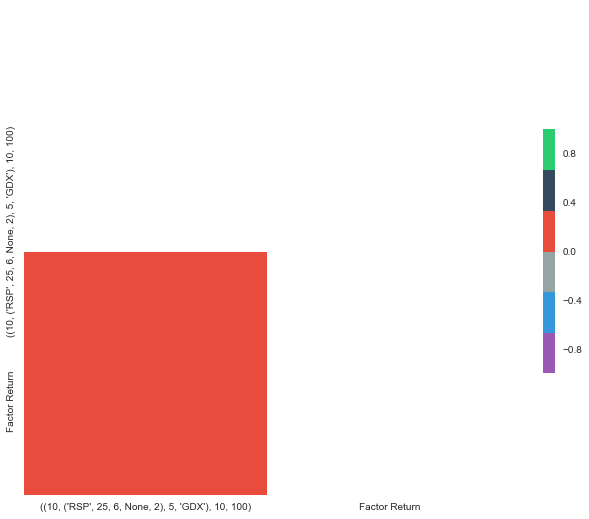

,"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)",Factor Return
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)",0.000157,0.000010
Factor Return,0.000010,0.000105


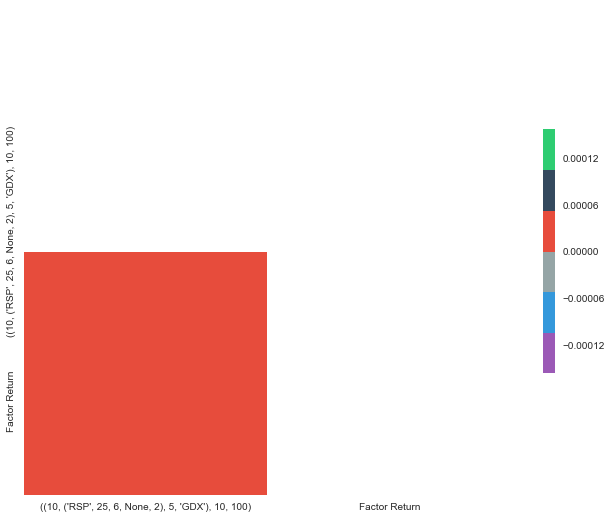

In [8]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [9]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 100)
UPLOAD ERROR: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x110d44908>)


KeyboardInterrupt: 

In [34]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="Simple Test GDX vs SPY", benchmark=factorToTrade)

PORTFOLIO HASH: 3321c4bb85a0f509464df2c78349c2a85f9a6b203d9f8630aa631fd7
bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e


In [35]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e']

In [36]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [37]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2009-03-02,-0.003404
2009-03-03,-0.035261
2009-03-04,0.006623
2009-03-05,-0.000000
2009-03-06,-0.006638
2009-03-09,0.058636
2009-03-10,-0.001771
2009-03-11,0.024087
2009-03-12,-0.004668
2009-03-13,-0.007910


In [38]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2009-03-02,-0.003404
2009-03-03,-0.035261
2009-03-04,0.006623
2009-03-05,-0.000000
2009-03-06,-0.006638
2009-03-09,0.058636
2009-03-10,-0.001771
2009-03-11,0.024087
2009-03-12,-0.004668
2009-03-13,-0.007910


,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2009-03-02,-0.25
2009-03-03,-0.50
2009-03-04,-0.25
2009-03-05,0.00
2009-03-06,0.50
2009-03-09,0.75
2009-03-10,0.75
2009-03-11,0.75
2009-03-12,0.75
2009-03-13,1.00


In [43]:
if len(allModels) > 1:
    hrpReturns, historicalWeights = portfolioGeneration.\
        produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
        22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
else:
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: 1.0, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)

In [44]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '3321c4bb85a0f509464df2c78349c2a85f9a6b203d9f8630aa631fd7', 'description': 'Super Strict vs EWZ', 'benchmark': 'EWZ'}
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
